In [50]:
from collections import OrderedDict
from copy import copy
import single_sided_network
import qdyn_model
from notebook_plots import display_hamiltonian
from sympy import Symbol
import QDYN
from QDYN.pulse import blackman
from QDYN.shutil import mkdir
import matplotlib.pylab as plt
import numpy as np
import sympy
from sympy import pi

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Circuit

In [52]:
circuit = single_sided_network.network_circuit(n_nodes=2, topology='bs_fb')

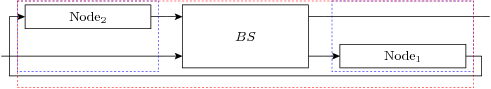

In [53]:
circuit.show()

In [54]:
slh = single_sided_network.network_slh(n_cavity=2, n_nodes=2, topology='bs_fb')

In [55]:
slh.S

[[1]]

In [56]:
slh.L

[[-sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₁) - sqrt(2)*sqrt(κ)*cos(θ)/(sin(θ) - 1) * â^(c₂)]]

In [8]:
def plot_bs_decay():
    from qnet.algebra.pattern_matching import pattern, wc
    from qnet.algebra.operator_algebra import ScalarTimesOperator
    θ = Symbol('theta', real=True)
    κ = Symbol('kappa', positive=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    theta = np.linspace(0, 2*np.pi, 100)
    L = slh.L[0, 0]
    k1_form, k2_form = [op.coeff for op in pattern(ScalarTimesOperator).findall(L)]
    k1_form = k1_form / sympy.sqrt(2*κ)
    k2_form = k2_form / sympy.sqrt(2*κ)
    k1 = np.array([k1_form.subs({θ: val}) for val in theta])
    k2 = np.array([k2_form.subs({θ: val}) for val in theta])
    ax.plot(theta/np.pi, k1)
    ax.plot(theta/np.pi, k2)
    ax.set_ylim(-3, 3)
    ax.set_xlabel(r'BS mixing angle $\theta$ ($\pi$ rad)')
    ax.set_ylabel(r'decay rate relative to open network')
    plt.show(fig)

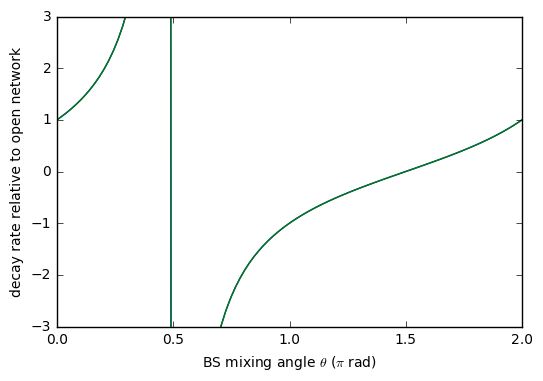

In [9]:
plot_bs_decay()

In [10]:
θ = Symbol('theta', real=True)
slh.L.substitute({θ: 3*pi/2}).simplify_scalar()

[[0]]

In [11]:
display_hamiltonian(slh.H)

<IPython.core.display.Latex object>

## Numerical Values

In [57]:
controls = sorted([sym for sym in slh.H.all_symbols() if sym.name.startswith('Omega')], key=str)

In [58]:
# from algebra import generate_num_vals_code
# generate_num_vals_code(slh.all_symbols())

In [59]:
Delta =  5000.0  # MHz
g     =    50.0  # MHz
kappa =     0.5  # MHz
E0    =    70.0  # MHz
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001
theta = 1.5 * np.pi
num_vals = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('g_2', positive=True):   g,
    Symbol('g_1', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('theta', real=True):     theta,
}

## Magnitude of coefficients

In [15]:
from qnet.algebra.pattern_matching import pattern
from qnet.algebra.operator_algebra import ScalarTimesOperator

In [16]:
{str(t.coeff): t.coeff.subs(num_vals) for t in pattern(head=ScalarTimesOperator).findall(slh.H)}

{'-I*Omega_1*g_1/(2*Delta_1)': -0.005*I*Omega_1,
 '-I*Omega_2*g_2/(2*Delta_2)': -0.005*I*Omega_2,
 '-I*kappa': -0.5*I,
 '-g_1**2/Delta_1': -0.500000000000000,
 '-g_2**2/Delta_2': -0.500000000000000,
 'I*Omega_1*g_1/(2*Delta_1)': 0.005*I*Omega_1,
 'I*Omega_2*g_2/(2*Delta_2)': 0.005*I*Omega_2,
 'I*kappa': 0.5*I,
 'g_1**2/Delta_1': 0.500000000000000,
 'g_2**2/Delta_2': 0.500000000000000}

## Time Grid and Guess Pulse

In [60]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [61]:
p = QDYN.pulse.Pulse(
    tgrid, amplitude=(E0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [62]:
controls = OrderedDict([
    (Symbol('Omega_1'), p.copy()),
    (Symbol('Omega_2'), p.copy()),
])

## OCT for forward transfer (hs)

In [20]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='excitation_transfer_fw',
    lambda_a=1e-4)

In [21]:
model.write_to_runfolder("./BS_FB/fw_oct_hs001/")

##  OCT for $\sqrt{SWAP}$ (hs)

In [63]:
sqrt_SWAP = QDYN.gate2q.Gate2Q([
    [1,             0,             0,   0],
    [0, -1/np.sqrt(2),  1/np.sqrt(2),   0],
    [0, -1/np.sqrt(2), -1/np.sqrt(2),   0],
    [0,             0,             0, -1j]]
)

In [64]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [65]:
model.write_to_runfolder("./BS_FB/sqrtSWAP_oct_hs001/")
sqrt_SWAP.write("./BS_FB/sqrtSWAP_oct_hs001/target_gate.dat")

##  OCT for SWAP (hs)

In [27]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-2)

In [28]:
model.write_to_runfolder("./BS_FB/SWAP_oct_hs001/")
QDYN.gate2q.SWAP.write("./BS_FB/SWAP_oct_hs001/target_gate.dat")

##  OCT for PE (hs)

In [29]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-2)

In [30]:
model.write_to_runfolder("./BS_FB/PE_oct_hs001/")
QDYN.gate2q.CPHASE.write("./BS_FB/PE_oct_hs001/target_gate.dat")

##  OCT for sqrtSWAP (LI, hs)

In [31]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [32]:
model.write_to_runfolder("./BS_FB/sqrtSWAP_oct_hsLI001/")
QDYN.gate2q.sqrt_SWAP.write("./BS_FB/sqrtSWAP_oct_hsLI001/target_gate.dat")

##  OCT for sqrtSWAP (hs, dissipative)

In [45]:
slh = single_sided_network.network_slh(n_cavity=2, n_nodes=2, topology='bs_fb')

In [46]:
sqrt_SWAP = QDYN.gate2q.Gate2Q([
    [1,             0,             0,   0],
    [0, -1/np.sqrt(2),  1/np.sqrt(2),   0],
    [0, -1/np.sqrt(2), -1/np.sqrt(2),   0],
    [0,             0,             0, -1j]]
)

In [47]:
num_vals_diss = num_vals.copy()
θ = Symbol('theta', real=True)
num_vals_diss[θ] = 0.25 * np.pi

In [48]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='gate',
    lambda_a=1e-4)

In [49]:
model.write_to_runfolder("./BS_FB/sqrtSWAP_diss_oct_hs001/")
sqrt_SWAP.write("./BS_FB/sqrtSWAP_diss_oct_hs001/target_gate.dat")

##  OCT for forward transfer (hs, dissipative)

In [74]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='excitation_transfer_fw',
    lambda_a=1e-4)

In [79]:
L = model.lindblad_ops()[0]

In [76]:
model.write_to_runfolder("./BS_FB/fw_diss_oct_hs001/")

##  OCT for dicke state initialization (hs, dissipative)

In [83]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals_diss, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='dicke',
    lambda_a=1e-4)

In [84]:
model.write_to_runfolder("./BS_FB/dicke_diss_oct_hs001/")

## Example optimization commands

*   hilbert space optimization

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --debug --J_T=J_T_re .```

*   trajectory optimization (model with `mcwf=True`)

    ```OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --n-trajs=20 --J_T=J_T_re .```